In [16]:
# Majority Vote Classifier

# Mathmatics basis
# ----------------
# 1. why is ensemble error more precise?
import math
from scipy.special import comb

def ensemble_error(n_classifier, error):
    k_major = int(math.ceil(n_classifier / 2.))
    proba = [(comb(n_classifier, k) * error**k * (1 - error)**(n_classifier - k)) 
             for k in range(k_major, n_classifier + 1)]
    return sum(proba)

print('Ensemble error %.3f' % ensemble_error(11, error=0.25))  # we can see that the ensemble error(0.034) is lower than single classifier error(0.25)

# 2. how majority vote work? 
# max(prediction x weights)
import numpy as np
labels = [0, 0, 1]
weights = [0.2, 0.2, 0.6]
result = np.argmax(np.bincount(labels, weights))  # calculate occurrences of values from 0 to max(list). if weights, +weight instead of +1
print(f'\nMajority Vote with label prediction \nlabels: {labels}\nweights: {weights}\nresult: {result}')

probabs = np.array([[0.9, 0.1], 
              [0.8, 0.2], 
              [0.4, 0.6]])
p = np.average(probabs, axis=0, weights=weights)
print(f'\nMajority Vote with probability prediction \nprobabs: \n{probabs}\nweights: {weights}\nresult: {p}')

Ensemble error 0.034

Majority Vote with label prediction 
labels: [0, 0, 1]
weights: [0.2, 0.2, 0.6]
result: 1

Majority Vote with probability prediction 
probabs: 
[[0.9 0.1]
 [0.8 0.2]
 [0.4 0.6]]
weights: [0.2, 0.2, 0.6]
result: [0.58 0.42]


In [17]:
# Manully realize a majority vote classifier
# ------------------------------------------
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='label', weights=None) -> None:
        self.classifiers = classifiers
        self.named_classifier = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        # error check
        if self.vote not in ('probability', 'label'):
            raise ValueError('Vote must be one of "probability" or "label";'
                             ' got (vote=%r)' % self.vote)
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal;'
                             ' got (weights=%d), (classifiers=%d)' %(len(self.weights), len(self.classifiers)))
        
        # important for label to be numerical
        self.labelencoder_ = LabelEncoder()
        self.labelencoder_.fit(y)
        self.classes_ = self.labelencoder_.classes_  # member for easy access to encoded classes.
        self.fitted_classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, 
                                        self.labelencoder_.transform(y))
            self.fitted_classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.fitted_classifiers_]).T
            maj_vote = np.apply_along_axis(lambda X: np.argmax(np.bincount(X,
                                                                           weights=self.weights)), axis=1, arr=predictions)
        maj_vote = self.labelencoder_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probabs = np.asarray([clf.predict_proba(X) for clf in self.fitted_classifiers_])
        avg_probabs = np.average(probabs, axis=0, weights=self.weights)
        return avg_probabs
    
    # override get_params method:
    # for easy access to _name_estimators.
    def get_params(self, deep: bool = True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifier.copy()
            for name, step in self.named_classifier.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s_%s' % (name, key)] = value
            return out

In [18]:
# apply new majority classifier
# -----------------------------
# iris dataset
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)
print(pd.DataFrame(X_train).head())

     0    1
0  2.6  4.0
1  2.7  5.1
2  3.0  5.9
3  2.8  5.6
4  2.3  4.0


In [19]:
# three type of classifiers:
# 1. Logistic Regression
# 2. Decision Tree
# 3. k-NN

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

lr = LogisticRegression(penalty='l2', C=0.01, solver='lbfgs', random_state=1)
clf_dt = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=1)
knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

# first use single classifier
clf_lr = Pipeline([['sc', StandardScaler()], 
                  ['clf', lr]])
clf_knn = Pipeline([['sc', StandardScaler()], 
                    ['clf', knn]])
clf_names = ['LogisticRegression', 'DecisionTree', 'KNN']
print('10-fold cross validation result: \n')
for clf, label in zip([clf_lr, clf_dt, clf_knn], clf_names):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

# second use vote classifier
clf_mv = MajorityVoteClassifier(classifiers=[clf_lr, clf_dt, clf_knn])
scores = cross_val_score(estimator=clf_mv, X=X_train, y=y_train,
                         cv=10, scoring='roc_auc')
print('ROC AUC: %0.2f (+/- %0.2f) [Majority voting]' % (scores.mean(), scores.std()))

10-fold cross validation result: 

ROC AUC: 0.92 (+/- 0.15) [LogisticRegression]
ROC AUC: 0.87 (+/- 0.18) [DecisionTree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


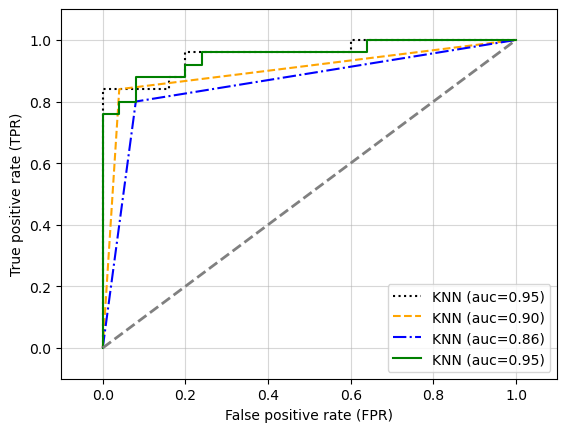

In [20]:
# evaluate mv classifiers
# -----------------------
# visualization

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
clf_names += ['Majority voting']
clf_list = [clf_lr, clf_dt, clf_knn, clf_mv]

for clf, name, col, ls in zip(clf_list, clf_names, colors, linestyles):
    # assuming the target label is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 
             color=col, 
             linestyle=ls, 
             label='%s (auc=%0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         color='gray', 
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

In [21]:
# adjust parameters to optimize model
clf_mv.get_params()  # from this function we can see all parameters we can tune

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.01, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1_memory': None,
 'pipeline-1_steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.01, random_state=1)]],
 'pipeline-1_verbose': False,
 'pipeline-1_sc': StandardScaler(),
 'pipeline-1_clf': LogisticRegression(C=0.01, random_state=1),
 'pipeline-1_sc__copy': True,
 'pipeline-1_sc__with_mean': True,
 'pipeline-1_sc__with_std': True,
 'pipeline-1_clf__C': 0.01,
 'pipeline-1_clf__class_weight': None,
 'pipeline-1_clf__dual': False,
 'pipeline-1_clf__fit_intercept': True,
 'pipeline-1_clf__intercept_scaling': 1,
 'pipeline-1_clf__l1_ratio': None,
 'pipeline-1_clf__max_iter': 100,
 'pipeline-1_clf__multi_class': 'auto',

In [24]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier_max_depth':[1, 2], 
          'pipeline-1_clf__C':[0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=clf_mv, 
                    param_grid=params, 
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print('%0.3f +/- %0.2f %r' % (grid.cv_results_['mean_test_score'][r], 
                                  grid.cv_results_['std_test_score'][r] / 2.0, 
                                  grid.cv_results_['params'][r]))
print('Best parameter: %s' % grid.best_params_)
print('Accuracy: %0.2f' % grid.best_score_)

0.983 +/- 0.02 {'decisiontreeclassifier_max_depth': 1, 'pipeline-1_clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier_max_depth': 1, 'pipeline-1_clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier_max_depth': 1, 'pipeline-1_clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier_max_depth': 2, 'pipeline-1_clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier_max_depth': 2, 'pipeline-1_clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier_max_depth': 2, 'pipeline-1_clf__C': 100.0}
Best parameter: {'decisiontreeclassifier_max_depth': 1, 'pipeline-1_clf__C': 0.001}
Accuracy: 0.98
